# Analysis of Reportable Hazardous Ingredients in California Cosmetic Products

Berrin Yuksel, 
CHIP690 Introduction to Programming 

## Introduction:

It is well established that certain ingredients and chemicals used in cosmetic products may
cause cancer, birth defects, or other reproductive and developmental harm. Some U.S. states
require companies to report these ingredients, and California is one of them. Under the
California Safe Cosmetics Act, any manufacturer, packer, or distributor listed on a cosmetic
product sold in California must report to the California Safe Cosmetics Program (CSCP) if
the product contains ingredients known or suspected to be harmful to human health.

In this project, dataset from California Department of Public Health’s California Safe
Cosmetics Program (CSCP) will be used to examine the reported chemical ingredients, the types
of products they appear in, and the companies that use them.

## Research Question:

Which five reportable ingredients are used most frequently, in which product categories they
appear most often, and which companies use them the most?

## Importing the required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import math

## Parameters 

In [2]:
# path of dataset csv
dataset_csv_path = "https://data.chhs.ca.gov/dataset/596b5eed-31de-4fd8-a645-249f3f9b19c4/resource/57da6c9a-41a7-44b0-ab8d-815ff2cd5913/download/cscpopendata.csv"

# top K chemicals found in the products listed in the dataset
K = 5

# top P features by cooccurence of most found chemicals in the dataset
P = 3

## Downloading dataset csv from web

In [3]:
response = requests.get(dataset_csv_path)
assert response.status_code == 200, f"Can't download {dataset_csv_path}"

# convert csv data to dataframe
df = pd.read_csv(io.StringIO(response.text))
print(f"{len(df)} entries in {dataset_csv_path}")

# make entries lower case for case-insensitivity
df['ChemicalName'] = df['ChemicalName'].str.lower()
df['CompanyName'] = df['CompanyName'].str.lower()
df['SubCategory'] = df['SubCategory'].str.lower()

114635 entries in https://data.chhs.ca.gov/dataset/596b5eed-31de-4fd8-a645-249f3f9b19c4/resource/57da6c9a-41a7-44b0-ab8d-815ff2cd5913/download/cscpopendata.csv


## Calculating occurence of chemicals

In [4]:
chemicals = np.array(df['ChemicalName'])

# Get unique chemical names and compute their counts
unique_chemicals, unique_chemical_counts = np.unique(chemicals, return_counts=True)

# Sort unique chemicals by their occurence
chem_indices_by_occur = np.argsort(-unique_chemical_counts) # negative sign for descending sorting
unique_chemicals = unique_chemicals[chem_indices_by_occur]
unique_chemical_counts = unique_chemical_counts[chem_indices_by_occur]

## Bar chart to visualize the occurence of top 5 chemicals

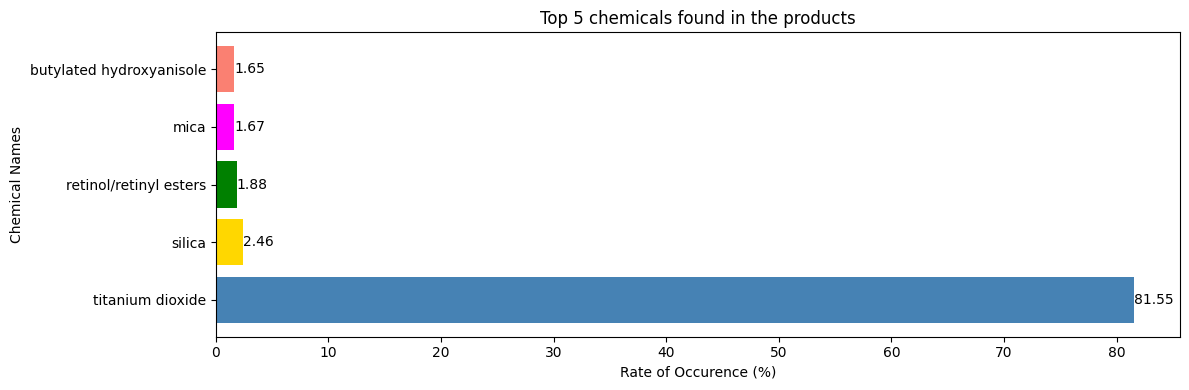

In [5]:
# top 5 found chemical names
most_used_chemicals = unique_chemicals[0: K]
labels = [chemical.split(',')[0] for chemical in most_used_chemicals]

# compute percentage of occurences and round the result
occurences = np.round(100 * unique_chemical_counts[0: K] / len(df), 2)

# draw colored bar chart from labels and occurences
bar_colors = ['steelblue', 'gold', 'green', 'magenta', 'salmon']
fig, ax = plt.subplots(figsize=(12,4))
bars = ax.barh(labels, occurences, color=bar_colors) 
ax.bar_label(bars)
ax.set_xlabel('Rate of Occurence (%)')
ax.set_ylabel('Chemical Names')
ax.set_title(f"Top {K} chemicals found in the products")
plt.tight_layout()
plt.show()

In [6]:
def get_p_items_with_max_values(dict_var, p):
    """
    Returns the keys of dictionary with maximum values
    Args:
        dict_var: dictionary to search
    Output:
        keys with maximum values
    """
    keys = np.array(list(dict_var.keys()))
    values = np.array(list(dict_var.values()))
    desc_ordered_indices = np.argsort(-values)  # negative sign for descending sort
    return keys[desc_ordered_indices][0: p], values[desc_ordered_indices][0: p]

def count_feature_cooccurrence_per_query(df, analyzed_column, query_column, query_name):
    """ 
    Returns a dictionary of number of occurences of query per values in analyzed column 
    Args:
        df: data frame including the query column and analyzed column
        query_name: query value searched in query column
        query_column: name of query column
        analyzed_column: name of analyzed column where query feature occurs in query column
    Output:
        feat_occ_dict: dictionary of number of occurences of query per values in analyzed column
    """

    # initialize an zeroes dictionary of unique entries in analyzed column
    keys = np.unique(np.array(df[analyzed_column]))  # unique entries in analyzed column
    feat_occ_dict = {}
    feat_occ_dict = dict.fromkeys(keys, 0)

    # iterate all entries and increase values of corresponding items
    for i in range(len(df)):
        if df[query_column][i] == query_name:
            feat_occ_dict[df[analyzed_column][i]] += 1
    return feat_occ_dict

## Pie Chart to visualize the top 5 chemical usage in product categories and companies

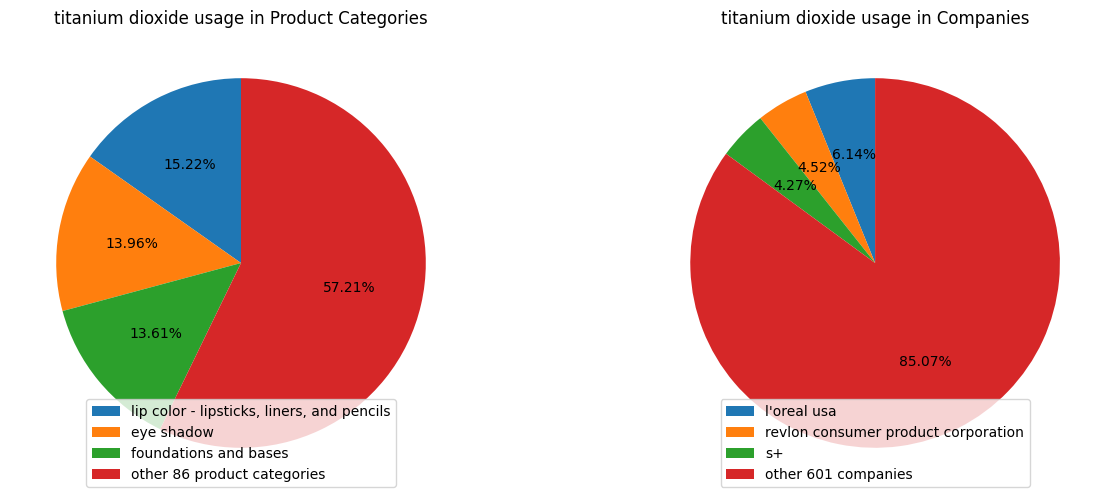

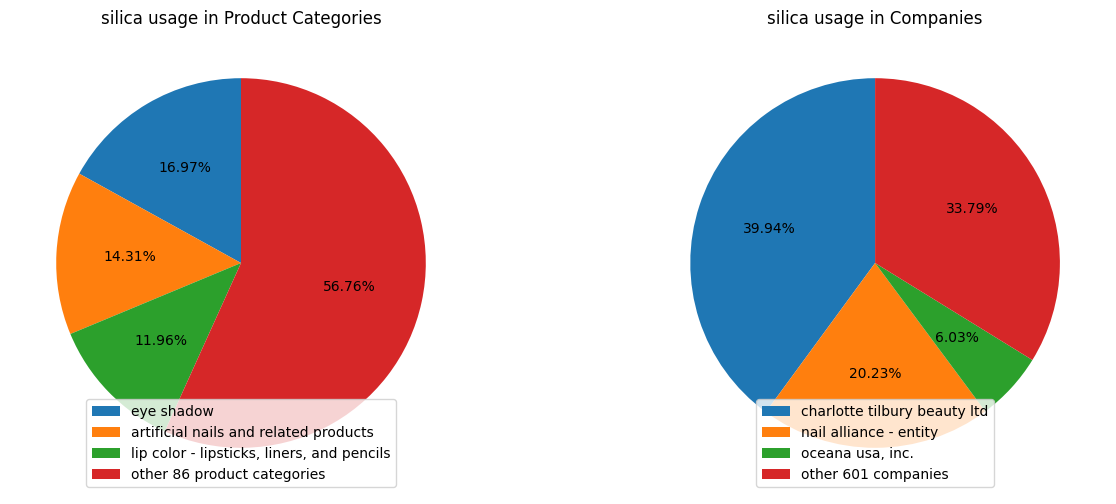

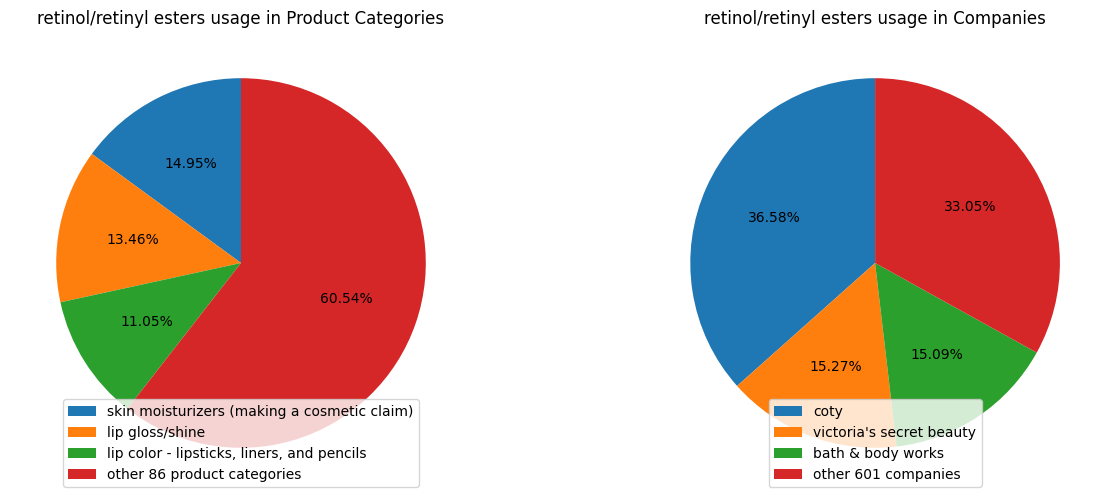

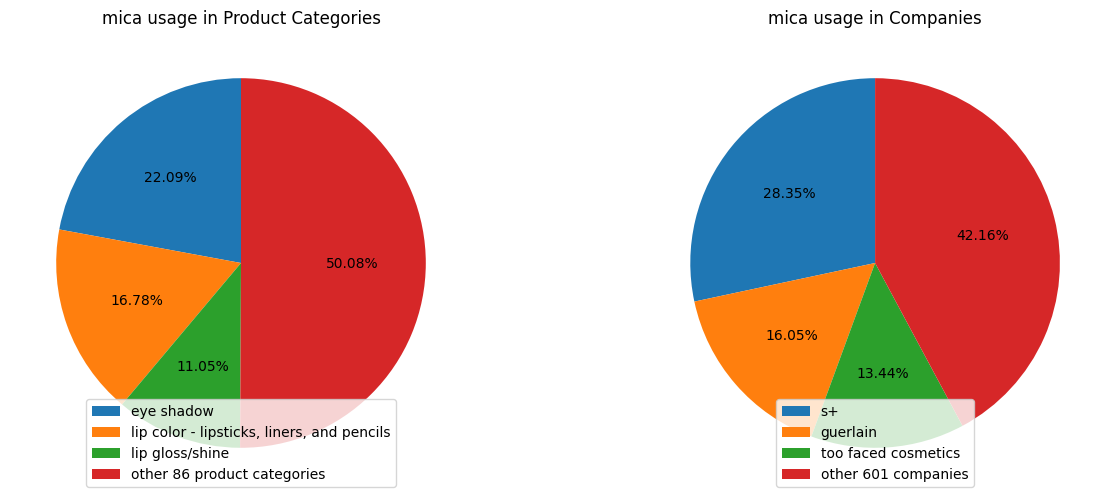

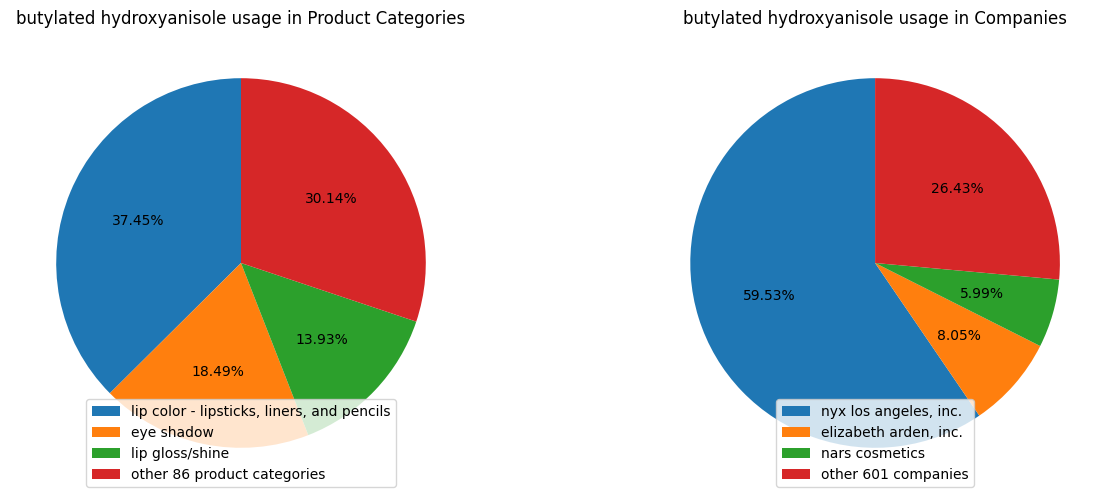

In [13]:
query_column = "ChemicalName"
for query_name in most_used_chemicals:

    plt.figure(figsize=(15, 6))
    
    for j, analyzed_column in enumerate(["SubCategory", "CompanyName"]):

        # generate dictionary of cooccurences of features in analyzed column per query name
        feat_occ_dict = count_feature_cooccurrence_per_query(df, analyzed_column, query_column, query_name)

        # get keys with maximum P values
        max_valued_keys, max_values = get_p_items_with_max_values(feat_occ_dict, p=P)

        # draw pie charts for usage of each chemical in analyzed columns by adding remaining values as others
        plt.subplot(1, 2, j + 1)
        remaining_value = sum(feat_occ_dict.values()) - sum(max_values)
        remaining_num_of_categories = len(feat_occ_dict.values()) - P  # total num - P
        feat_cooccurence_data = np.append(max_values, remaining_value)
        plt.pie(feat_cooccurence_data, startangle=90, autopct='%1.2f%%')
        if j == 0:
            plt.title(f"{query_name.split(",")[0]} usage in Product Categories")
            plt.legend(np.append(max_valued_keys, f"other {remaining_num_of_categories} product categories"), loc="lower center")
        else:
            plt.title(f"{query_name.split(",")[0]} usage in Companies")
            plt.legend(np.append(max_valued_keys, f"other {remaining_num_of_categories} companies"), loc="lower center")
            
    plt.show()